In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

## **Processing of the dataset**

In [103]:
%run dataset.py

[*********************100%***********************]  1 of 1 completed

S&P 500 data processed.
Data saved as 'processed_data.csv'.


In [104]:
data = pd.read_csv('data/processed_data.csv', index_col=0)
data.head()

,Close,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,,
2005-02-01,1189.410034,9.251176,1.797314,-0.549336,-0.070571,-1.054000,1.480793
2005-02-02,1193.189941,11.402198,1.628523,0.722583,0.862218,0.432633,0.686745
2005-02-03,1189.890015,7.089487,1.306029,1.231909,0.184395,0.519542,0.642527
2005-02-04,1203.030029,17.700814,2.703699,3.010612,2.172498,1.274530,0.414279
2005-02-07,1201.719971,14.341911,1.731183,3.262726,1.452061,1.309236,0.390989


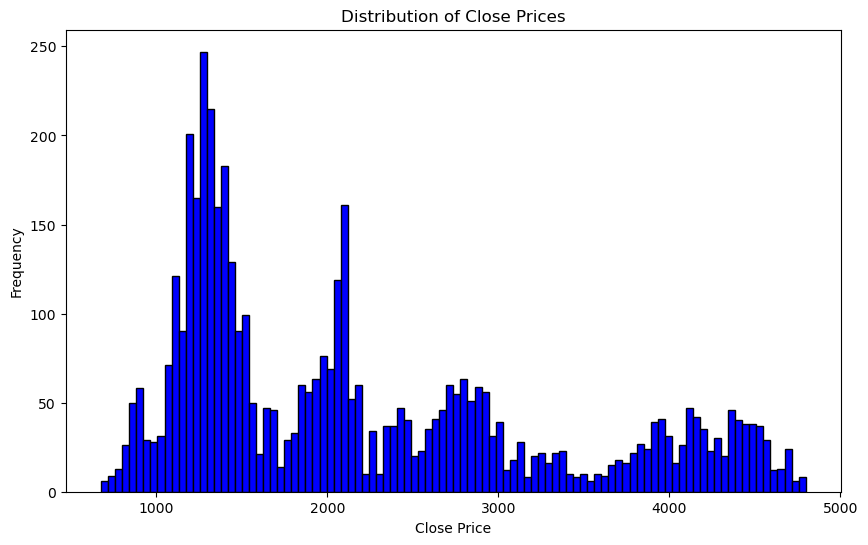

In [105]:
plt.figure(figsize=(10, 6))
plt.hist(data['Close'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.show()

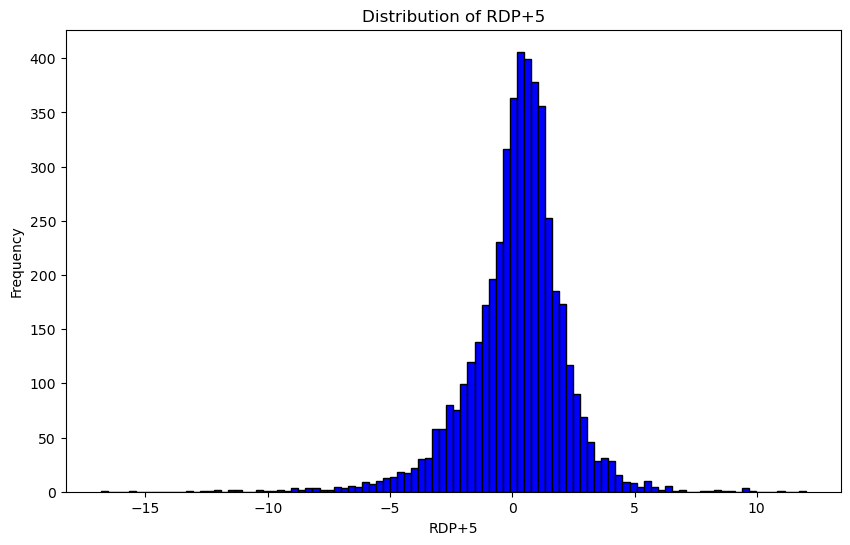

In [106]:
plt.figure(figsize=(10, 6))
plt.hist(data['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

### **Outliers**

In [107]:
def handle_outliers(dataframe, columns):
    """
    Replace outliers in specified columns with the closest marginal value.
    
    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to process.
    - columns (list): List of column names to apply outlier handling.
    
    Returns:
    - pd.DataFrame: DataFrame with outliers replaced.
    """
    for col in columns:
        mean = dataframe[col].mean()
        std_dev = dataframe[col].std()
        upper_limit = mean + 2 * std_dev
        lower_limit = mean - 2 * std_dev
        
        dataframe[col] = np.where(dataframe[col] > upper_limit, upper_limit, dataframe[col])
        dataframe[col] = np.where(dataframe[col] < lower_limit, lower_limit, dataframe[col])
    
    return dataframe

def scale_columns(dataframe, columns):
    """
    Scale the specified columns of a DataFrame to the range [-0.9, 0.9].

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame.
    - columns (list): List of column names to scale.

    Returns:
    - pd.DataFrame: DataFrame with scaled columns.
    """
    scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
    dataframe[columns] = scaler.fit_transform(dataframe[columns])
    return dataframe

In [108]:
data_scaled = handle_outliers(data, columns=['RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = scale_columns(data_scaled, columns=['EMA15','RDP+5', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20'])
data_scaled = data_scaled.drop(columns=['Close'])
print(data_scaled.shape)
data_scaled.head()

(4756, 6)


,EMA15,RDP_5,RDP_10,RDP_15,RDP_20,RDP+5
Date,,,,,,
2005-02-01,0.427594,0.298879,-0.122540,-0.065974,-0.171376,0.288841
2005-02-02,0.433592,0.267746,0.051282,0.038701,-0.024821,0.114253
2005-02-03,0.421567,0.208264,0.120888,-0.037362,-0.016253,0.104530
2005-02-04,0.451154,0.466056,0.363968,0.185738,0.058175,0.054345
2005-02-07,0.441788,0.286682,0.398423,0.104892,0.061596,0.049224


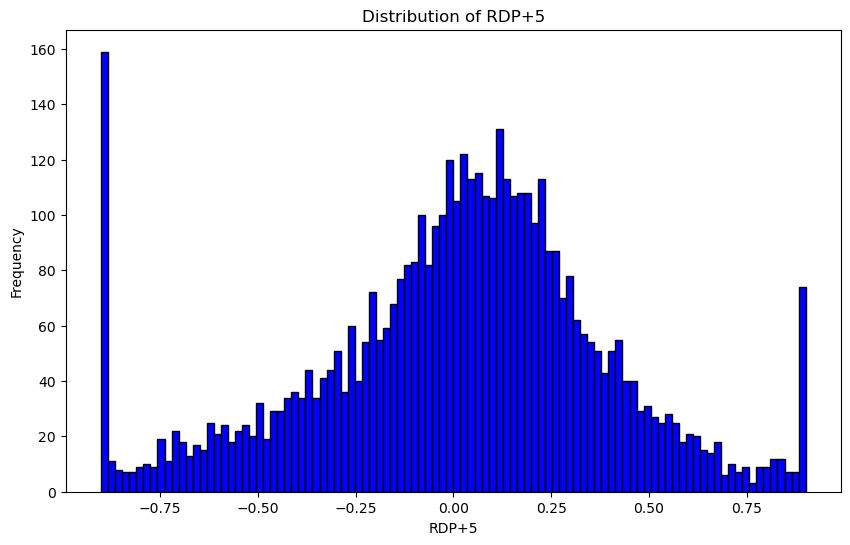

In [109]:
plt.figure(figsize=(10, 6))
plt.hist(data_scaled['RDP+5'],bins=100, color='blue', edgecolor='black')
plt.xlabel('RDP+5')
plt.ylabel('Frequency')
plt.title('Distribution of RDP+5')
plt.show()

## Splitting the data into Training-Validation-Testing

In [110]:
def split_data(dataframe, train_ratio=0.7, val_ratio=0.15):
    """
    Split the data into training, validation, and testing sets.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame to split.
    - train_ratio (float): Proportion of data for training (default: 0.7).
    - val_ratio (float): Proportion of data for validation (default: 0.15).

    Returns:
    - tuple: (train_data, val_data, test_data)
    """
    train_end = int(len(dataframe) * train_ratio)
    val_end = train_end + int(len(dataframe) * val_ratio)

    train_data = dataframe[:train_end]
    val_data = dataframe[train_end:val_end]
    test_data = dataframe[val_end:]

    return train_data, val_data, test_data

In [111]:
train_data, val_data, test_data = split_data(data_scaled)

print(f'Training data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Testing data: {test_data.shape}')

Training data: (3329, 6)
Validation data: (713, 6)
Testing data: (714, 6)


In [112]:
# SVM Regression Training and Evaluation
def train_and_evaluate_svm(train_data, val_data, test_data, features, target):
    """
    Train and evaluate an SVM regression model on the given data.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - test_data (pd.DataFrame): Testing dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.

    Returns:
    - dict: A dictionary containing the model, predictions, and evaluation metrics.
    """
    # Prepare training, validation, and testing data
    X_train = train_data[features]
    y_train = train_data[target]

    X_val = val_data[features]
    y_val = val_data[target]

    X_test = test_data[features]
    y_test = test_data[target]

    # Train the SVR model
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)

    # Validate the model
    val_predictions = svr.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_nmse = val_mse / np.var(y_val)
    val_r2 = r2_score(y_val, val_predictions)

    print(f"Validation MSE: {val_mse:.4f}")
    print(f"Validation NMSE: {val_nmse:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    # Test the model
    test_predictions = svr.predict(X_test)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_nmse = test_mse / np.var(y_test)
    test_r2 = r2_score(y_test, test_predictions)

    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test NMSE: {test_nmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Return results
    return {
        "model": svr,
        "val_predictions": val_predictions,
        "test_predictions": test_predictions,
        "y_test": y_test,
        "validation_metrics": {"mse": val_mse, "r2": val_r2},
        "test_metrics": {"mse": test_mse, "r2": test_r2},
    }

# Plot Predictions vs Actual Values
def plot_predictions(y_test, test_predictions, start_idx=0, end_idx=100):
    """
    Plot predictions vs actual values for a specified range.

    Parameters:
    - y_test (pd.Series): Actual target values from the test set.
    - test_predictions (np.ndarray): Predicted target values from the test set.
    - start_idx (int): Starting index for the range to plot.
    - end_idx (int): Ending index for the range to plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[start_idx:end_idx], label='Actual Values', color='blue')
    plt.plot(test_predictions[start_idx:end_idx], label='Predicted Values', color='red', linestyle='--')
    plt.title('SVM Regression: Predicted vs Actual')
    plt.xlabel('Index')
    plt.ylabel('RDP+5')
    plt.legend()
    plt.show()

Validation MSE: 0.1588
Validation NMSE: 0.9922
Validation R²: 0.0078
Test MSE: 0.1820
Test NMSE: 1.0480
Test R²: -0.0480


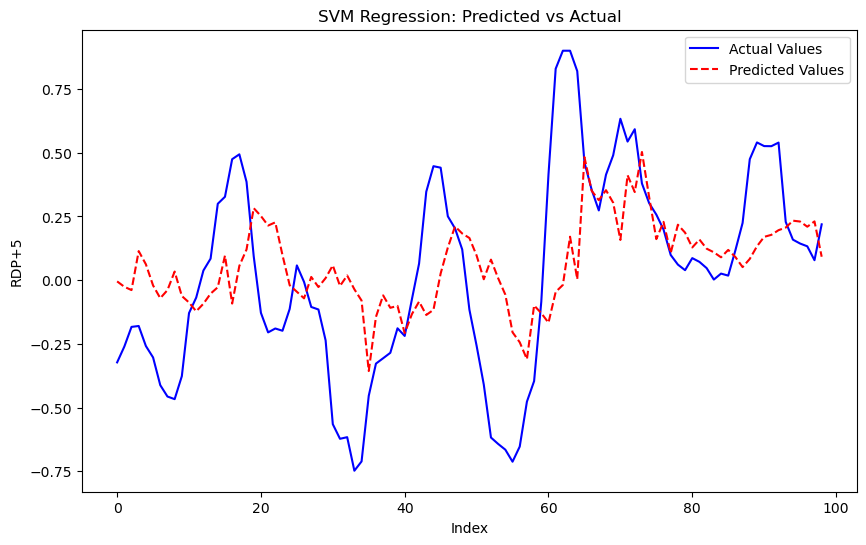

In [113]:
features = ['EMA15', 'RDP_5', 'RDP_10', 'RDP_15', 'RDP_20']
target = 'RDP+5'
results = train_and_evaluate_svm(train_data, val_data, test_data, features, target)
plot_predictions(results['y_test'], results['test_predictions'], start_idx=-100, end_idx=-1)

### **Optimisation of the Hyper-parameters**

In [117]:
from sklearn.model_selection import GridSearchCV

def optimize_svm(train_data, val_data, features, target, param_grid):
    """
    Optimize the SVM hyperparameters using GridSearchCV.

    Parameters:
    - train_data (pd.DataFrame): Training dataset.
    - val_data (pd.DataFrame): Validation dataset.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - param_grid (dict): Dictionary specifying hyperparameter ranges for GridSearchCV.

    Returns:
    - dict: Best hyperparameters and the optimized model.
    """
    # Combine training and validation sets for optimization
    combined_data = pd.concat([train_data, val_data])
    X_combined = combined_data[features]
    y_combined = combined_data[target]

    # Initialize the SVR model
    svr = SVR(kernel='rbf')

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=svr,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1  # Use all available cores
    )

    # Perform the grid search
    grid_search.fit(X_combined, y_combined)

    # Extract the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best hyperparameters: {best_params}")

    # Train the final model using the best hyperparameters
    best_model = grid_search.best_estimator_

    return {
        "best_model": best_model,
        "best_params": best_params,
        "grid_search": grid_search
    }

In [124]:
# Define hyperparameter grid
param_grid = {
    "C": [0.001, 0.1, 1, 10],
    "epsilon": [0.001, 0.01, 0.1],
    "gamma": [0.001 ,0.01, 0.1, 1]
}
# Optimize hyperparameters
optimization_results = optimize_svm(train_data, val_data, features, target, param_grid)

# Evaluate the best model on the test set
best_model = optimization_results["best_model"]
X_test = test_data[features]
y_test = test_data[target]
# Test the model
test_predictions = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_nmse = test_mse / np.var(y_test)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test NMSE: {test_nmse:.4f}")
print(f"Test R²: {test_r2:.4f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ................C=0.001, epsilon=0.001, gamma=0.001; total time=   1.0s
[CV] END ................C=0.001, epsilon=0.001, gamma=0.001; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.001, gamma=0.01; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.001, gamma=0.01; total time=   1.0s
[CV] END ................C=0.001, epsilon=0.001, gamma=0.001; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.001, gamma=0.01; total time=   1.0s
[CV] END ..................C=0.001, epsilon=0.001, gamma=0.1; total time=   1.0s
[CV] END ..................C=0.001, epsilon=0.001, gamma=0.1; total time=   0.9s
[CV] END ..................C=0.001, epsilon=0.001, gamma=0.1; total time=   1.0s
[CV] END ....................C=0.001, epsilon=0.001, gamma=1; total time=   1.0s
[CV] END ....................C=0.001, epsilon=0.001, gamma=1; total time=   1.0s
[CV] END .................C=0.001, epsilon=0.01

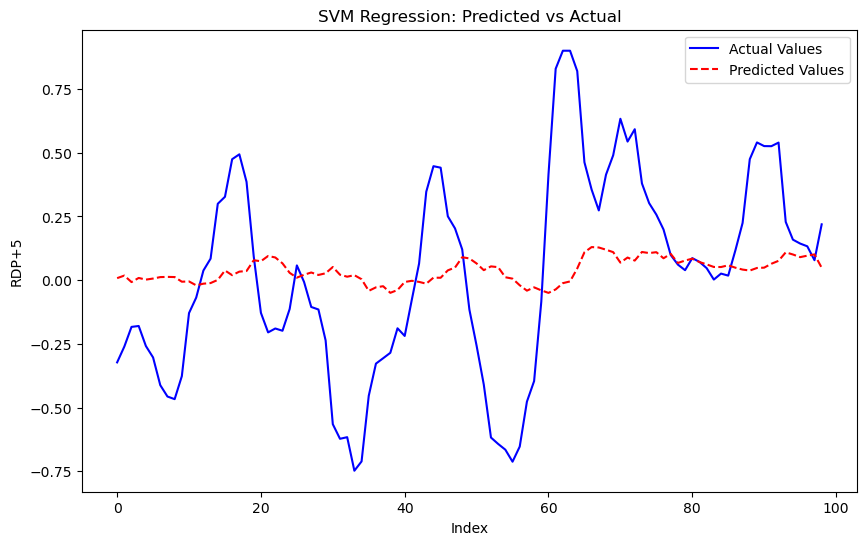

In [125]:
# Plot predictions for a specific range (e.g., last 100 data points)
plot_predictions(y_test, test_predictions, start_idx=-100, end_idx=-1)